In [10]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

In [11]:
df = wrangle_311(spark)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments


In [12]:
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)


df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
only show

In [13]:
# only 33 are not subject...not enough data for much. So, I'll remove that column. 
df.groupBy('dept_subject_to_SLA').count().show()

+-------------------+------+
|dept_subject_to_SLA| count|
+-------------------+------+
|               true|841671|
|              false|    33|
+-------------------+------+



In [14]:
(
    df
    .withColumn('diff_days2closed_caselifetime', col('days_to_closed') - col('case_lifetime'))
    .groupBy('case_status').agg(mean('diff_days2closed_caselifetime'))
    .show()
)

+-----------+----------------------------------+
|case_status|avg(diff_days2closed_caselifetime)|
+-----------+----------------------------------+
|       Open|                              null|
|     Closed|                               0.0|
+-----------+----------------------------------+



In [15]:
df.groupBy('case_closed', 'case_status').count().show()

+-----------+-----------+------+
|case_closed|case_status| count|
+-----------+-----------+------+
|       true|     Closed|823594|
|      false|       Open| 18110|
+-----------+-----------+------+



In [16]:
df = df.drop('dept_subject_to_SLA', 'days_to_closed', 'case_closed', 'case_id', 'source_id', 'request_address', 'zipcode',
             'case_opened_date', 'case_closed_date', 'case_due_date'
            )

In [17]:
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)


df shape: (841704, 10)

-RECORD 0------------------------------------
 case_late            | false                
 num_days_late        | -998.5087616000001   
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 case_age             | 219                  
 case_lifetime        | 0                    
 department           | Animal Care Services 
only showing top 1 row



In [18]:
# simple summary table

df.groupby("case_status").count().show()

+-----------+------+
|case_status| count|
+-----------+------+
|       Open| 18110|
|     Closed|823594|
+-----------+------+



In [19]:
df.groupby("case_status").agg(mean("case_lifetime")).show()

+-----------+------------------+
|case_status|avg(case_lifetime)|
+-----------+------------------+
|       Open| 82.87338487023744|
|     Closed| 9.108407461102653|
+-----------+------------------+



Text(0.5, 0, 'Number of Cases')

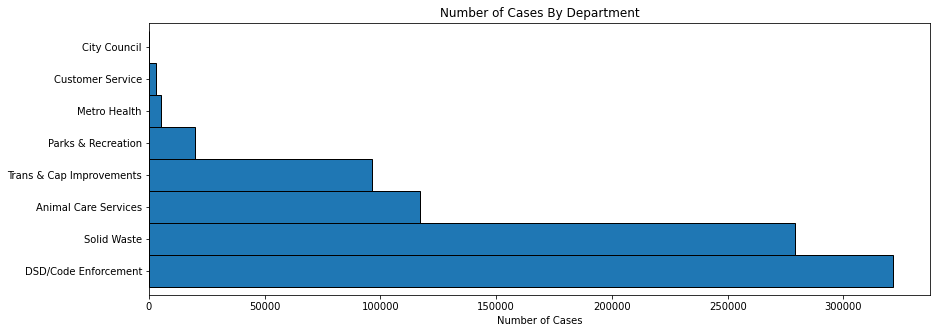

In [20]:
# First aggregate with spark
(
    df.groupBy("department")
    .count()
    # then pass to pandas
    .toPandas()
    .set_index("department")["count"]
    .sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

plt.title("Number of Cases By Department")
plt.ylabel("")
plt.xlabel("Number of Cases")

Text(0.5, 1.0, 'Case Lifetime By Department')

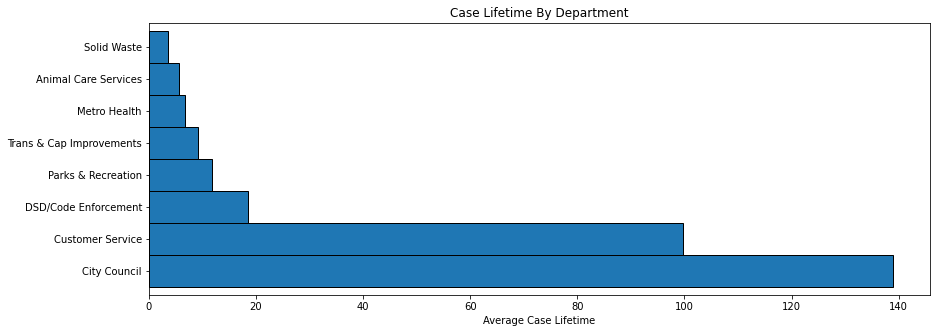

In [21]:
# first aggregate with spark
(
    df.groupBy("department")
    .agg(mean("case_lifetime").alias("avg_case_lifetime"))
    # then pass the data to pandas for visualization
    .toPandas()
    .set_index("department")
    .avg_case_lifetime.sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

plt.xlabel("Average Case Lifetime")
plt.ylabel("")
plt.title("Case Lifetime By Department")

In [22]:
(
    df.groupBy("department")
    .pivot("case_status")
    .agg(round(mean("case_lifetime"), 2))
    .orderBy("Closed")
    .show(truncate=False)
)

+------------------------+------+------+
|department              |Closed|Open  |
+------------------------+------+------+
|Solid Waste             |3.4   |16.45 |
|Animal Care Services    |5.51  |21.36 |
|Metro Health            |6.82  |4.64  |
|Trans & Cap Improvements|8.0   |54.39 |
|Parks & Recreation      |10.66 |64.72 |
|DSD/Code Enforcement    |15.65 |91.56 |
|City Council            |29.25 |154.07|
|Customer Service        |48.94 |172.94|
+------------------------+------+------+



In [25]:
pd_df = df.toPandas()

<Figure size 1152x648 with 0 Axes>

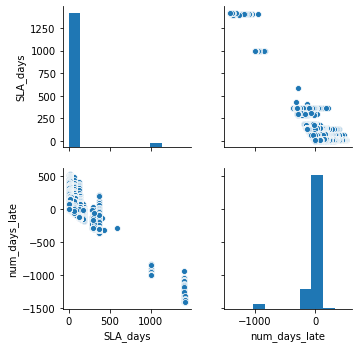

In [28]:
plt.figure(figsize=(16, 9))
sns.pairplot(pd_df[['SLA_days', 'num_days_late']])

In [29]:
sample = df.sample(fraction=0.01, seed=13).toPandas()
print("shape:", sample.shape)
sample.head()

shape: (8357, 10)


,case_late,num_days_late,service_request_type,SLA_days,case_status,council_district,num_weeks_late,case_age,case_lifetime,department
0,False,-14.706007,Front Or Side Yard Parking,16.058646,Closed,004,-2.100858,219,1,DSD/Code Enforcement
1,True,28.957257,Animal Neglect,5.000000,Closed,001,4.136751,219,34,Animal Care Services
2,False,-56.938229,Overgrown Yard/Trash,64.781146,Closed,010,-8.134033,219,8,DSD/Code Enforcement
3,False,-85.690104,Signal Timing Modification,85.714537,Closed,002,-12.241443,219,0,Trans & Cap Improvements
4,False,-998.822014,Stray Animal,999.000000,Closed,005,-142.688859,219,0,Animal Care Services


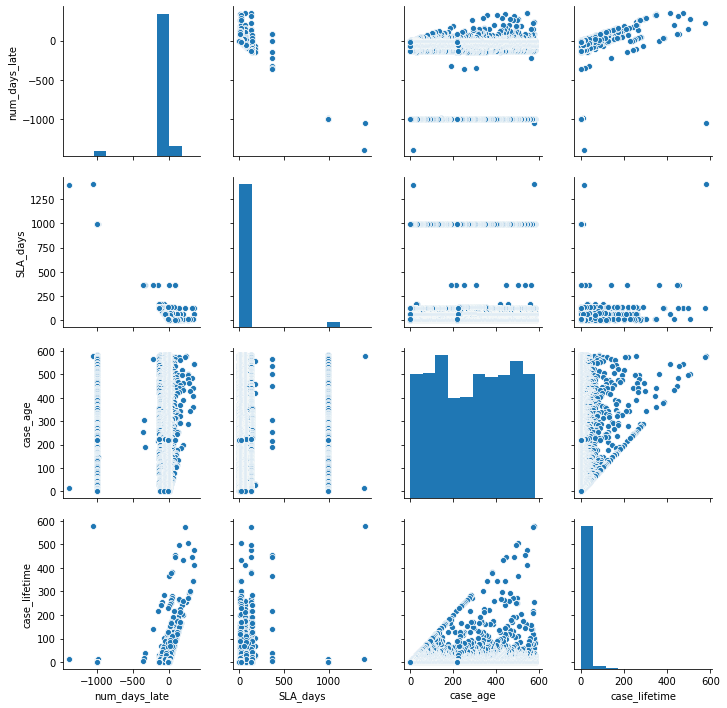

In [31]:
numeric_cols = [
    "num_days_late",
    "SLA_days",
    "case_age",
    "case_lifetime",
]

sns.pairplot(sample[numeric_cols])

In [32]:
df.groupBy('case_status').count().withColumn('prop', col('count')/df.count()).show()
# let's stratify by case_status

+-----------+------+--------------------+
|case_status| count|                prop|
+-----------+------+--------------------+
|       Open| 18110|0.021515877315540857|
|     Closed|823594|  0.9784841226844592|
+-----------+------+--------------------+



In [33]:
sampled = df.sampleBy("case_status", fractions={'Closed': .05, 'Open': 1.0}, seed=235)

In [34]:
sampled = sampled.toPandas()

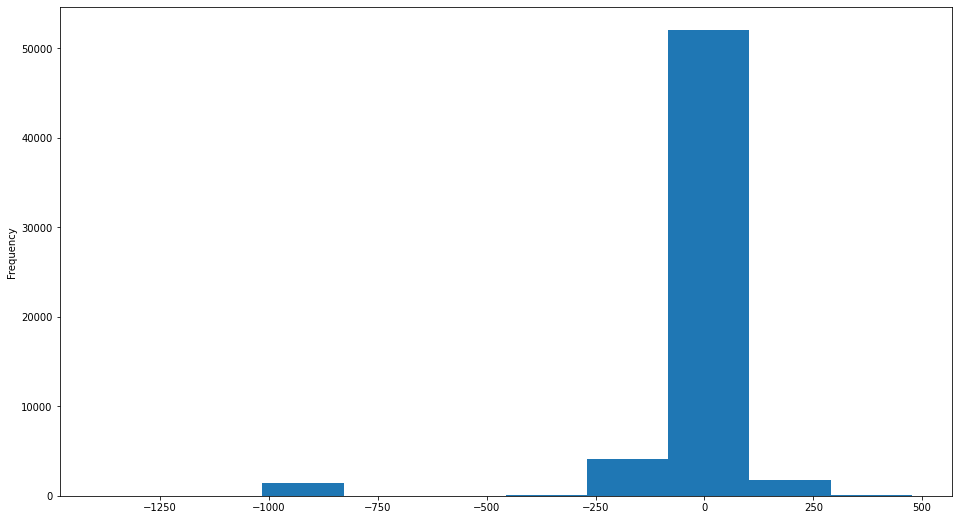

In [36]:
plt.figure(figsize=(16, 9))


sampled['num_days_late'].plot.hist()

In [37]:
df.crosstab('case_status', 'case_late').show()

+---------------------+------+-----+
|case_status_case_late| false| true|
+---------------------+------+-----+
|               Closed|735616|87978|
|                 Open| 11585| 6525|
+---------------------+------+-----+



In [38]:
df.groupBy('council_district').count().show()

+----------------+------+
|council_district| count|
+----------------+------+
|             009| 40916|
|             006| 74095|
|             005|114609|
|             003|102706|
|             008| 42345|
|             001|119309|
|             010| 62926|
|             004| 93778|
|             000|  3830|
|             007| 72445|
|             002|114745|
+----------------+------+



In [39]:
df.groupBy('department').count().show()

+--------------------+------+
|          department| count|
+--------------------+------+
|         Solid Waste|279270|
|Animal Care Services|116915|
|Trans & Cap Impro...| 96193|
|  Parks & Recreation| 19907|
|    Customer Service|  2849|
|        Metro Health|  5163|
|        City Council|    33|
|DSD/Code Enforcement|321374|
+--------------------+------+



In [40]:
parks_rec = df.filter(col('department') == lit('Parks & Recreation')).toPandas()


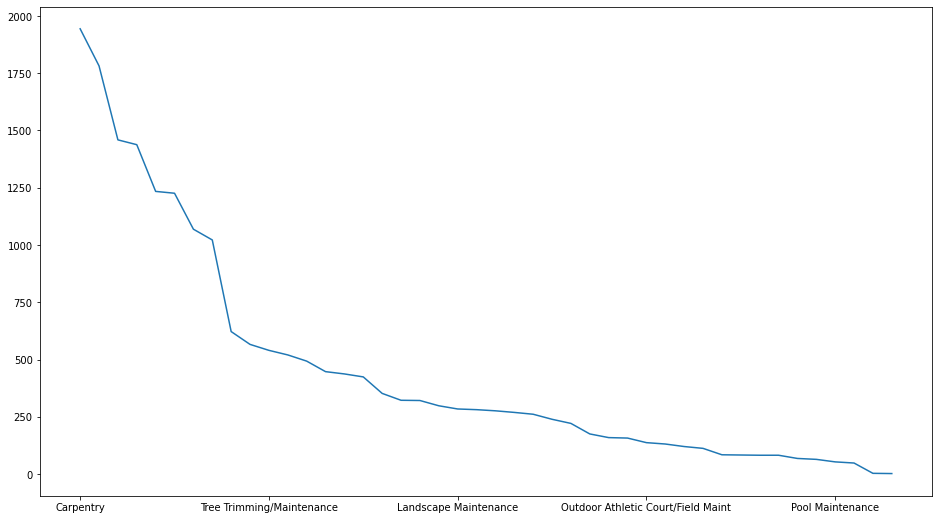

In [49]:
plt.figure(figsize=(16, 9))
parks_rec.service_request_type.value_counts().plot()